Find ROI from fish scan using NN
====

In [4]:
"""
Download the metadata from the mastersheet

"""

import os
import subprocess

if not os.path.exists("uCT_mastersheet.csv"):
    subprocess.run(
        [
            "wget",
            "https://raw.githubusercontent.com/wahabk/ctfishpy/master/ctfishpy/Metadata/uCT_mastersheet.csv",
        ],
        check=True,
    )

In [5]:
# Directory path for RDSF fish data
rdsf_dir = os.path.expanduser("~/zebrafish_rdsf/")

data_dir = os.path.join(rdsf_dir, "DATABASE/uCT/Wahab_clean_dataset/low_res_clean_v3/")

print(data_dir)
assert os.path.isdir(data_dir)

/home/mh19137/zebrafish_rdsf/DATABASE/uCT/Wahab_clean_dataset/low_res_clean_v3/


In [6]:
# Choose a directory to use
# 71, 70, 
n = 73

In [15]:
# Read the images into an array
import cv2
import numpy as np
import pathlib
from tqdm import tqdm


def read_tif(path):
    return cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)


def tifs2array(tif_dir: pathlib.Path, *, progress: bool = False) -> np.ndarray:
    """
    Read in all the tifs in a directory and return them as a numpy array

    """
    paths = sorted(list(tif_dir.glob("*.tiff")))

    progress_fcn = tqdm if progress else lambda x: x
    tifs = [read_tif(path) for path in progress_fcn(paths)]

    return np.stack(tifs, axis=0)


def n2dir(n: int) -> pathlib.Path:
    return pathlib.Path(f"{data_dir}/{n:03}/reconstructed_tifs/")


tif_dir = n2dir(n)
print(tif_dir)

array = tifs2array(tif_dir)
array.shape

/home/mh19137/zebrafish_rdsf/DATABASE/uCT/Wahab_clean_dataset/low_res_clean_v3/044/reconstructed_tifs


(2000, 596, 634)

In [16]:
# Get the jaw centre from metadata
import re
from functools import cache

import pandas as pd


@cache
def _metadata() -> pd.DataFrame:
    return pd.read_csv("uCT_mastersheet.csv")


def get_roi(n: int) -> tuple[int, int, int]:
    """Z X Y centre of region of interest"""
    metadata = _metadata()
    loc = metadata["old_n"] == n

    # Find the jaw centre - should be a len 1 series
    centre = metadata.loc[loc, "jaw_center"]
    assert len(centre) == 1

    # Convert to a tuple
    centre = tuple(map(int, re.findall(r"\d+", centre.iloc[0])))
    return centre

    # Convert to co ords that can be used for indexing
    # TODO figure out if/when this is needed
    # It seems like sometimes you need to do this, and sometimes you don't
    shape = metadata.loc[loc, "shape"]
    assert len(shape) == 1

    _, width, height = tuple(map(int, re.findall(r"\d+", shape.iloc[0])))

    return centre[0], width - centre[1], height - centre[2]


roi = get_roi(n)
roi

(1759, 298, 376)

In [17]:
# Crop the image to the jaw centre
def crop_image(
    image: np.ndarray, roi: tuple[int, int, int], size: int = 160
) -> np.ndarray:
    z, x, y = roi
    return image[
        z - size // 2 : z + size // 2,
        x - size // 2 : x + size // 2,
        y - size // 2 : y + size // 2,
    ]


cropped_array = crop_image(array, roi)
cropped_array.shape

(160, 160, 160)

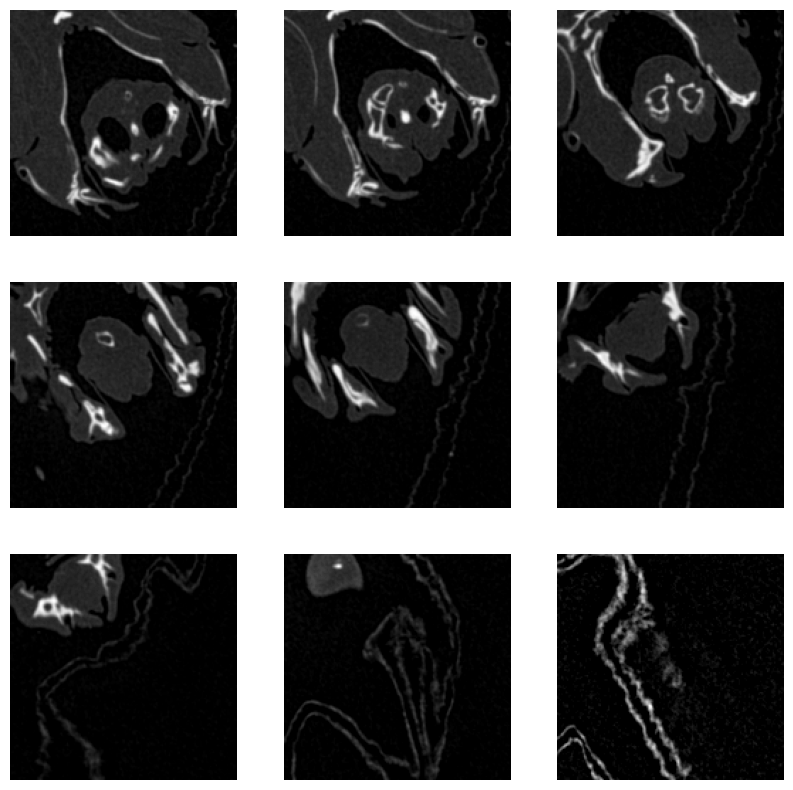

In [18]:
# Show slices of cropped jaw
import matplotlib.pyplot as plt


def plot_slices(arr: np.ndarray):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for axis, i in zip(
        axes.flat,
        [0, 10, 30, 50, 70, 90, 110, 130, 150],
    ):
        axis.imshow(arr[i], cmap="gray")
        axis.axis("off")

plot_slices(cropped_array)

In [ ]:
# Convert the image to patches
import torchio as tio
sampler = tio.GridSampler()

In [8]:
# Create a model for learning the jaw centre
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResNet3D(nn.Module):
    def __init__(self):
        super(ResNet3D, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv3d(
            in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.bn1 = nn.BatchNorm3d(64)

        self.conv2 = nn.Conv3d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        )
        self.bn2 = nn.BatchNorm3d(128)

        self.conv3 = nn.Conv3d(
            in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1
        )
        self.bn3 = nn.BatchNorm3d(256)

        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 20 * 20 * 20, 256)
        self.fc2 = nn.Linear(256, 3)  # Output layer for 3 coordinates

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = ResNet3D()
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

ResNet3D(
  (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048000, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [125]:
# Make a diagram of the architecture
from torchviz import make_dot

dummy_input = torch.randn(1, 1, 160, 160, 160)
dummy_output = model(dummy_input)

graph = make_dot(dummy_output, params=dict(model.named_parameters()))

graph.render("model", format="png")

'model.png'

In [11]:
# Convert some arrays into numpy arrays
import pathlib
from multiprocessing import Pool

array_dir = pathlib.Path("arrays/")
array_dir.mkdir(exist_ok=True)

# Choose some arrays to save
array_ns = [44, 68, 414]

In [12]:
def save_array(n: int) -> None:
    if not (array_dir / f"{n}.npy").exists():
        array = tifs2array(n2dir(n), progress=False)
        np.save(array_dir / f"{n}.npy", array)


# Will need to change this as array_ns gets bigger
with Pool(processes=len(array_ns)) as pool:
    pool.map(
        save_array,
        array_ns,
    )

In [14]:
# Check them
import numpy as np

for n in array_ns:
    arr = np.load(array_dir / f"{n}.npy")
    roi = get_roi(n)
    cropped_array = crop_image(arr, roi)
    plot_slices(cropped_array)

NameError: name 'crop_image' is not defined

In [148]:
# Reshape the arrays into a format that the model can use
train_arrs = [np.expand_dims(np.load(array_dir / f"{n}.npy"), axis=0) for n in array_ns]
print(train_arrs[0].shape)

(1, 2000, 596, 634)


In [1]:
# Get the jaw centres from the metadata
centres = [get_roi(n) for n in array_ns]
centres

NameError: name 'array_ns' is not defined

In [ ]:
# Parse the jaw centres to get the right numbers out

In [ ]:
# Train the model on a few jaws, look at training loss etc
